In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
%matplotlib inline

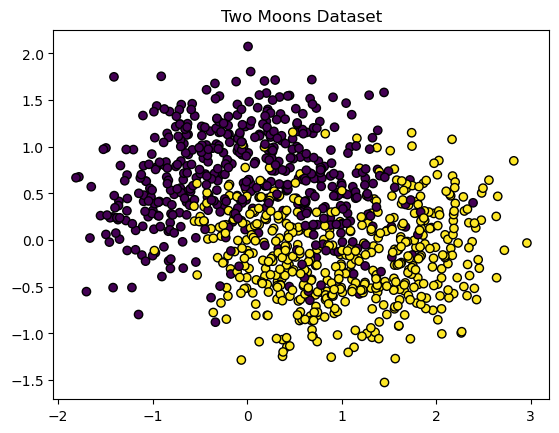

In [2]:
# Generate the two moons dataset
X, y = make_moons(n_samples=1000, noise=0.4, random_state=0)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
plt.title('Two Moons Dataset')
plt.show()


In [5]:
# As you know we need to split the data into training, validation and test
x_train=X[0:800,:]
y_train=y[0:800].astype(int)

x_val=X[800:900,:]
y_val=y[800:900].astype(int)

x_test=X[900:1000,:]
y_test=y[900:1000].astype(int)

x_train.shape

(800, 2)

In [6]:
#define utility functions
def linear(x,w):
    assert x.shape[1]==w.shape[0]
    return x@w

def softmax(scores):
    max = np.max(scores, axis=1, keepdims=True)
    exp = np.exp(scores - max)
    sum_exp = np.sum(exp, axis=1, keepdims=True)
    return exp/sum_exp

# Binary cross-entropy loss
def binary_cross_entropy(pred, y):
    epsilon = 1e-15  # To prevent log(0)
    pred = np.clip(pred, epsilon, 1 - epsilon)
    return -np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the RBF kernel function
def rbf_kernel(X1, X2, gamma):
    diff = X1[:, np.newaxis, :] - X2[np.newaxis, :, :]
    squared_dist = np.sum(diff ** 2, axis=2)
    return np.exp(-gamma * squared_dist)


def evaluate_model(X, y, w, pr=True):

    # Add bias term to test data
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    # Make predictions
    scores = X @ w
    predictions = (1 / (1 + np.exp(-scores))) >= 0.5

    # Calculate accuracy
    accuracy = np.mean(predictions == y)
    if pr:
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

def draw_decision_boundary(X, y, w, centroids, gamma, kernel=True):
    """
    Draw the decision boundary for logistic regression or kernelized logistic regression.

    """
    # Determine input space for the raw data
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a mesh grid for plotting decision boundary
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Prepare the grid for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]

    
    

    # Apply kernel transformation if a kernel function is provided
    if kernel:
        grid_transformed = rbf_kernel(grid, centroids, gamma)  # Transform grid using the kernel
    else:
        grid_transformed = grid  # Use raw grid

    #add bias term  
    grid_transformed = np.hstack([grid_transformed, np.ones((grid_transformed.shape[0], 1))])

    # Compute the scores using the trained weights
    scores_grid = grid_transformed @ w

    # Apply the sigmoid function to get probabilities
    Z = sigmoid(scores_grid).reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 6))

    # Plot the contour where probability is 0.5
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.8, cmap=plt.cm.RdBu_r)

    # Plot the original data points
    if X is not None and y is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=50)
    elif y is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=50)

    plt.title('Logistic Regression Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


In [7]:
def logistic_regression_train(x_train, y_train, plot=True, nr_iters=1000, learning_rate=0.001):

    losses = []

    # Add bias term to the feature matrix
    X = np.hstack([x_train, np.ones((x_train.shape[0], 1))])  # Add bias term as the last column
    n_features = X.shape[1]
    
    # Initialize weights
    w = np.zeros(n_features)

    for i in range(nr_iters):
        # Compute predictions
        scores = X @ w
        pred = sigmoid(scores)
            
        # Compute loss
        loss = binary_cross_entropy(pred, y_train)
        losses.append(loss)
            
        # Compute gradient
        grad = X.T @ (pred - y_train)
            
        # Update weights
        w -= learning_rate * grad

        #print(f"Iteration {i}, Loss: {loss}")

    # Plot the loss over iterations
    if plot:
        plt.plot(range(1, len(losses)+1), losses, marker='o')
        plt.title('Loss over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()

    return w


## Logistic Regression without kernel machine

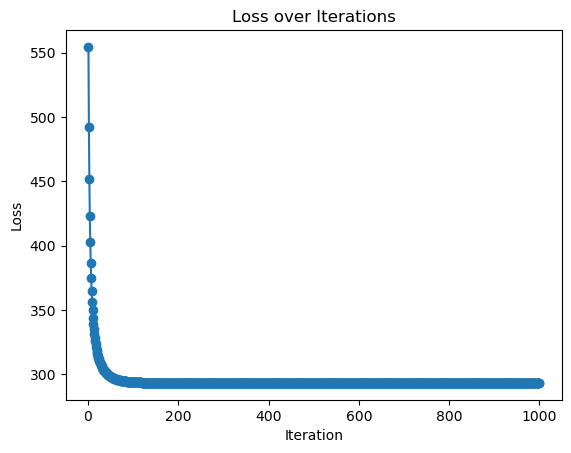

Test Accuracy: 78.00%


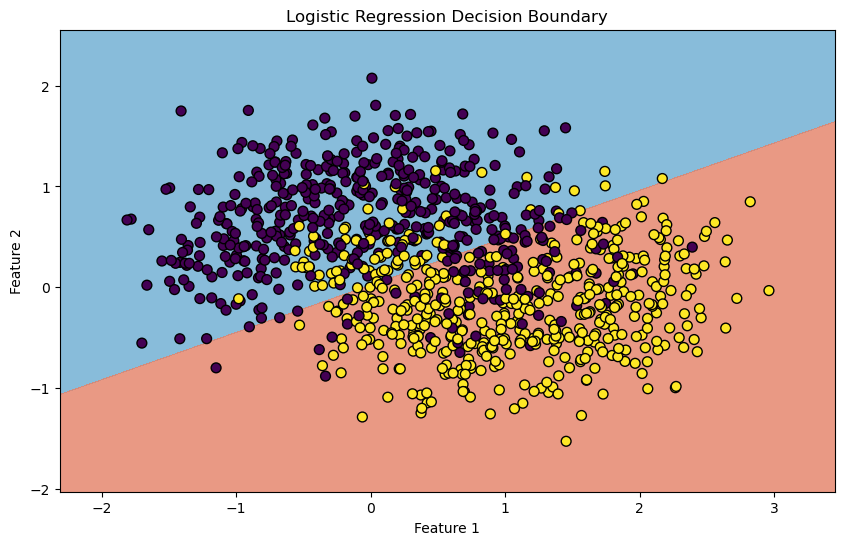

In [8]:
w = logistic_regression_train(x_train, y_train)

evaluate_model(x_test, y_test, w)

draw_decision_boundary(X, y, w, centroids=None, gamma=None, kernel=False)

## TODO: Logistic Regression with kernel machine:
- choose 20 centroids
- choose a good gamma value for the RBF Kernel by grid search (in logistic_regression_train: use plot=False, evaluate_model: use pr=False)
- train your logistic regression model with transformed data (use logistic_regression_train(..) use plot=True)
- evaluate your model (use evaluate_model(..), pr=True)
- plot the decision boundary (use draw_decision_boundary(..), kernel=True)

In [11]:
# TODO: choose 20 centroids
np.random.seed(42)  # for reproducibility
centroid_indices = np.random.choice(x_train.shape[0], size=20, replace=False)
centroids = x_train[centroid_indices]


In [15]:
# TODO: implement grid search function for gamma
def grid_search_gamma(x_train, y_train, x_val, y_val, centroids, gamma_values, nr_iters=1000, learning_rate=0.001):
    best_gamma = None
    best_acc = 0.0
    for gamma in gamma_values:
        # Transform training data with RBF (NO bias here—train fn adds it)
        X_train_transformed = rbf_kernel(x_train, centroids, gamma)

        # Train logistic regression (adds bias internally)
        w = logistic_regression_train(X_train_transformed, y_train, plot=False, nr_iters=nr_iters, learning_rate=learning_rate)

        # Transform validation data and ADD bias once (to match w length)
        X_val_transformed = rbf_kernel(x_val, centroids, gamma)
        X_val_transformed = np.hstack([X_val_transformed, np.ones((X_val_transformed.shape[0], 1))])

        # Compute predictions and accuracy in kernel space
        scores = X_val_transformed @ w
        predictions = (1 / (1 + np.exp(-scores))) >= 0.5
        acc = np.mean(predictions == y_val)

        if acc > best_acc:
            best_acc = acc
            best_gamma = gamma

    return best_gamma, best_acc

# TODO: find best gamma with your implemented grid search function
gamma_values = [0.1, 0.5, 1, 2, 5]
best_gamma, best_acc = grid_search_gamma(x_train, y_train, x_val, y_val, centroids, gamma_values)


In [16]:
# TODO: transform data using RBF Kernel with best gamma
X_train_transformed = rbf_kernel(x_train, centroids, best_gamma)
X_test_transformed  = rbf_kernel(x_test,  centroids, best_gamma)

# NOTE: Do NOT add bias here; the training function will add it internally.


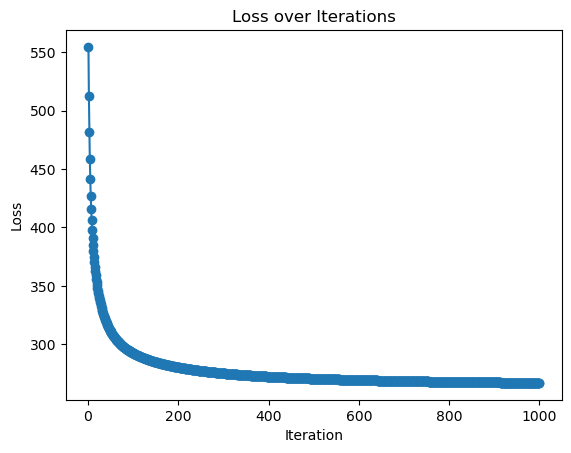

In [17]:
# TODO: train model
w_kernel = logistic_regression_train(X_train_transformed, y_train, plot=True, nr_iters=1000, learning_rate=0.001)


In [22]:
# TODO: evaluate model (should be better test accuracy than raw logistic regression, got 84%, before test accuracy was 78%)
# Transform test data and ADD bias once to match w_kernel
X_test_eval = np.hstack([X_test_transformed, np.ones((X_test_transformed.shape[0], 1))])
scores_test = X_test_eval @ w_kernel
predictions_test = (1 / (1 + np.exp(-scores_test))) >= 0.5
test_acc = np.mean(predictions_test == y_test)
print(f"Kernelized Logistic Regression Test Accuracy: {test_acc * 100:.2f}%")


Kernelized Logistic Regression Test Accuracy: 84.00%


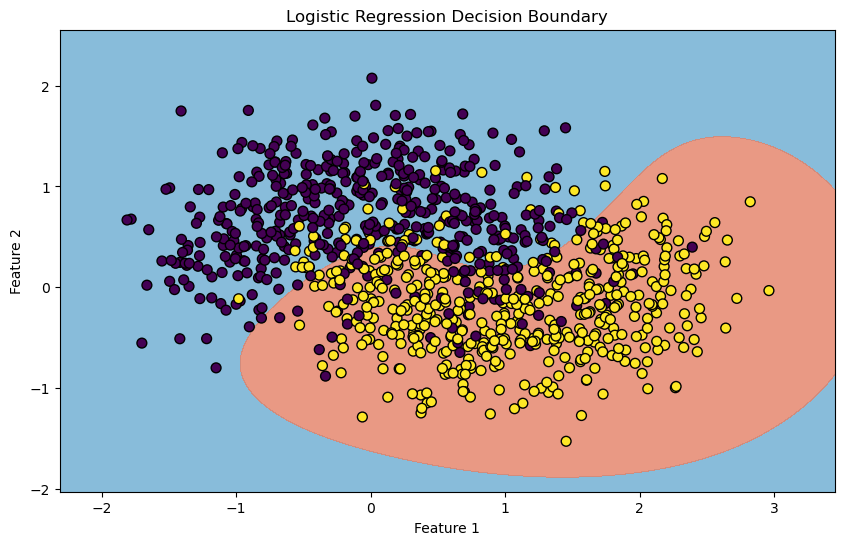

In [23]:
# TODO: plot decision boundary (should look non-linear unlike raw logistic regression)
draw_decision_boundary(X, y, w_kernel, centroids=centroids, gamma=best_gamma, kernel=True)
